In [ ]:
import pandas as pd
import numpy as np
ml1m_dir = 'data/ml-1m/ratings.dat'
ml1m_rating = pd.read_csv(ml1m_dir, sep='::', header=None, names=['uid', 'mid', 'rating', 'timestamp'],  engine='python')
# Reindex
user_id = ml1m_rating[['uid']].drop_duplicates().reindex()
user_id['userId'] = np.arange(len(user_id))

In [6]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
# arr = np.array([[[1,1,1]], [[0,0,0]]])
arr = np.array([[1,1,1], [0,0,0]])
# print(cosine_similarity(arr[0], arr[1]))
df = pd.DataFrame(arr)


[[0.]]


In [8]:
import numpy as np
import pandas as pd
arr = np.array([2, 3, 4, 1, 7, 6, 5,9])
print(arr)
idx = np.argpartition(arr, -3)[-3:]
print(idx)

[2 3 4 1 7 6 5 9]


In [3]:
%matplotlib inline
!python train.py

CHECKING NEUMF MODEL NEUMF(
  (embedding_user_mlp): Embedding(6040, 32)
  (embedding_item_mlp): Embedding(3706, 32)
  (embedding_user_mf): Embedding(6040, 8)
  (embedding_item_mf): Embedding(3706, 8)
  (fc_layers): ModuleList(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=8, bias=True)
  )
  (affine_output): Linear(in_features=16, out_features=1, bias=True)
  (logistic): Sigmoid()
)
GMF EMBEDDING MATRIX:
 [[ 4.2369556  -0.46066347 -0.34775916 ...  3.2856486   2.8583658
   0.5076846 ]
 [ 2.6124003  -0.41612935 -1.453515   ... -0.69536775  2.0840468
   0.58575237]
 [ 1.1238974  -0.62608325 -2.4099607  ...  2.1529627   1.2911468
   0.3595113 ]
 ...
 [ 1.755269   -0.7596729  -0.5051413  ...  2.285805    3.3321123
   0.3313915 ]
 [ 2.472516   -0.8227992   2.395214   ...  2.5955443   3.0729115
   0.43591842]
 [-0.4103414  -0.71189505 -1.4355265  ...  1.528711    4.3497324
  

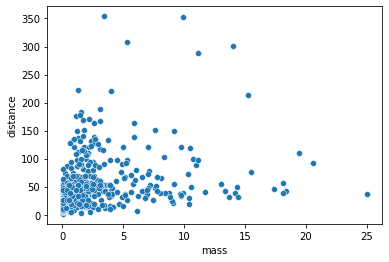

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

my_data = sns.load_dataset ('planets')

sns.scatterplot(x = 'mass', y ='distance', data=my_data)
plt.show()

In [76]:
import pandas as pd
import numpy as np
import itertools
# from torch import cosine_similarity
from sklearn.metrics.pairwise import cosine_similarity
from neumf import NEUMF
import torch
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def massgingOfData(ml1m_rating):
    user_id = ml1m_rating[['uid']].drop_duplicates().reindex()
    user_id['userId'] = np.arange(len(user_id))
    ml1m_rating = pd.merge(ml1m_rating, user_id, on=['uid'], how='left')
    item_id = ml1m_rating[['mid']].drop_duplicates()
    item_id['itemId'] = np.arange(len(item_id))
    ml1m_rating = pd.merge(ml1m_rating, item_id, on=['mid'], how='left')
    ml1m_rating = ml1m_rating[['userId', 'itemId', 'rating', 'timestamp']]
    return ml1m_rating

def ReadFile(filename, seperator):
    ml1m_dir = filename
    ml1m_rating = pd.read_csv(ml1m_dir, sep=seperator, header=None, names=['uid', 'mid', 'rating', 'timestamp'],  engine='python')
    return ml1m_rating

def ExtractCoreUsers(dataframe):
    print("# of rows in ml1m_ratings: ", len(dataframe))
    u_len = len(dataframe['userId'].drop_duplicates())
    print("USER LEN:", u_len)
    # print(user_id)

    m_len = len(dataframe['itemId'].drop_duplicates())
    print("MOVIE LEN:", m_len)
    userItemMatrix = np.zeros(shape=(u_len, m_len))
    # print(userItemMatrix)

    for index, row in dataframe.iterrows():
        userItemMatrix[row['userId']][row['itemId']] = 1
        # print(row['uid'], row['mid'])
    print("USER ITEM MATRIX: \n", userItemMatrix)

    df = pd.DataFrame(userItemMatrix)
    cosineSimilarity = cosine_similarity(df)
    print("SHAPE OF COSINE MATIX:\n ", cosineSimilarity.shape)

    listToStoreTopFiftyOfEveryUser = []
    for i in range(0, cosineSimilarity.shape[0]):
        idx = np.argpartition(cosineSimilarity[i], -50)[-50:]
        listToStoreTopFiftyOfEveryUser.append(idx)
    # print("Top fifty list: \n", listToStoreTopFiftyOfEveryUser)
    # listToStoreTopFiftyOfEveryUser = np.array(listToStoreTopFiftyOfEveryUser)
    flatten = np.concatenate(listToStoreTopFiftyOfEveryUser)
    listToStoreTopFiftyOfEveryUser = flatten.ravel()

    print("List of top 50", listToStoreTopFiftyOfEveryUser)
    df = pd.DataFrame(listToStoreTopFiftyOfEveryUser)
    allUserList = df.value_counts().index.tolist()
    print("ALL USERS LIST", allUserList)
    allUserList = list(sum(allUserList,()))
    print("ALL USERS LIST", allUserList)
    twentyPercentUserList = allUserList[:int(len(allUserList)*0.2)]
    # print("TWENTY PERCENT USER:", len(twentyPercentUserList))
    print("TWENTY PERCENT USER:", (twentyPercentUserList))
    coreusers = dataframe.iloc[np.where(dataframe.userId.isin(twentyPercentUserList))]
    print("CORE USERS:\n", coreusers)
    return coreusers
def ExtractEmbeddings(nuemf_pretrain_file_path):
    neumf_config = {'alias': 'pretrain_neumf_factor8neg4',
            'num_epoch': 15,
            'batch_size': 1024,
            'optimizer': 'adam',
            'adam_lr': 1e-3,
            'num_users': 6040,
            'num_items': 3706,
            'latent_dim_mf': 8,
            'latent_dim_mlp': 32,
            'num_negative': 4,
            'layers': [64,32,16,8],  # layers[0] is the concat of latent user vector & latent item vector
            'l2_regularization': 0,
            'use_cuda': True,
            'device_id': 0,
            'pretrain': True,
            'pretrain_mf': 'checkpoints/{}'.format('gmf_factor8neg4-implict_Epoch19_HR0.6141_NDCG0.3438.model'),
            'pretrain_mlp': 'checkpoints/{}'.format('mlp_factor8neg4_bz256_166432168_pretrain_reg_0.0000001_Epoch14_HR0.5561_NDCG0.3142.model'),
            'model_dir':'checkpoints/{}_Epoch{}_HR{:.4f}_NDCG{:.4f}.model'
            }
    neumf_model = NEUMF(neumf_config)
    embedding_matrix_gmf = neumf_model.GetEmbeddings(neumf_model, nuemf_pretrain_file_path)
    print("GMF EMBEDDING MATRIX:\n", embedding_matrix_gmf)
    return embedding_matrix_gmf


def plotTsne(dataset, coreUsersList, coreuserdataset):
    print('core user len:', len(coreUsersList))
    tsne = TSNE(n_components=2, verbose=1, random_state=123)
    z = tsne.fit_transform(dataset)
    df2 = pd.DataFrame()
    
    df2["feature-1"] = z[:,0]
    df2["feature-2"] = z[:,1]
    dfclass = ['non-core-users'] * dataset.shape[0]
    for i in coreUsersList:
        dfclass[i] = 'core-users'
    df2["users-category"] = dfclass
    print(df2.groupby(['users-category']).size())
    sns.scatterplot(x="feature-2", y="feature-1", hue='users-category',
        data=df2).set(title="t-SNE Movielens")   
    # plt.legend(loc = 2, bbox_to_anchor = (1,1)) 
    plt.show()
def main():
    # df = ReadFile('data/ml-1m/ratings.dat', '::')
    # df = massgingOfData(df)
    # print("DATAFRAME", df)
    # cu = ExtractCoreUsers(df)
    # print(len(cu['userId'].drop_duplicates()))
    # print(len(cu['itemId'].drop_duplicates()))
    # cu.to_csv('data/coreusers.csv', index=False)

    nuemf_pretrain_file_path = 'nuemf_state_files/nuemf_mov_8_256_0_sgd_Epoch3_HR0.6719_NDCG0.3992.model'
    gmf_embeddings = ExtractEmbeddings(nuemf_pretrain_file_path)
    cu = ReadFile('data/coreusers.csv', ',')
    coreUsersList = cu['uid'].drop_duplicates()
    userEmbeddingList = []
    for user in coreUsersList:
        userEmbeddingList.append(gmf_embeddings[user])
    print(len(userEmbeddingList))

    print('unique core users:', len(coreUsersList.unique()))
    plotTsne(gmf_embeddings, coreUsersList, userEmbeddingList)
    pass



if __name__ == "__main__":
    main()

TypeError: GetEmbeddings() takes 2 positional arguments but 3 were given

In [77]:
%matplotlib inline
!python train.py

CHECKING NEUMF MODEL NEUMF(
  (embedding_user_mlp): Embedding(6040, 32)
  (embedding_item_mlp): Embedding(3706, 32)
  (embedding_user_mf): Embedding(6040, 8)
  (embedding_item_mf): Embedding(3706, 8)
  (fc_layers): ModuleList(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=8, bias=True)
  )
  (affine_output): Linear(in_features=16, out_features=1, bias=True)
  (logistic): Sigmoid()
)
GMF EMBEDDING MATRIX:
 [[ 4.007131   -1.3495187  -2.1583004  ...  8.02472     3.1448848
   2.108149  ]
 [ 3.7842004  -5.7044325  -0.90566224 ... -0.06655385  4.791941
  -0.50042254]
 [ 0.09873994 -4.0470614  -1.613766   ...  0.5001575   3.5376039
   2.1278856 ]
 ...
 [ 4.640872   -1.4072827  -0.06775953 ...  4.2427635   2.883787
   3.5492458 ]
 [ 5.7692237  -0.46730456  0.66575897 ...  3.1025157   5.8835855
   5.066171  ]
 [ 4.945528   -1.3728007   1.2980158  ...  4.113479    1.0411538
   1

In [1]:
%matplotlib inline
%run train.py

In get embeddings:

CHECKING NEUMF MODEL NEUMF(
  (embedding_user_mlp): Embedding(6040, 32)
  (embedding_item_mlp): Embedding(3706, 32)
  (embedding_user_mf): Embedding(6040, 8)
  (embedding_item_mf): Embedding(3706, 8)
  (fc_layers): ModuleList(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=8, bias=True)
  )
  (affine_output): Linear(in_features=16, out_features=1, bias=True)
  (logistic): Sigmoid()
)
GMF EMBEDDING MATRIX:
 [[ 4.007131   -1.3495187  -2.1583004  ...  8.02472     3.1448848
   2.108149  ]
 [ 3.7842004  -5.7044325  -0.90566224 ... -0.06655385  4.791941
  -0.50042254]
 [ 0.09873994 -4.0470614  -1.613766   ...  0.5001575   3.5376039
   2.1278856 ]
 ...
 [ 4.640872   -1.4072827  -0.06775953 ...  4.2427635   2.883787
   3.5492458 ]
 [ 5.7692237  -0.46730456  0.66575897 ...  3.1025157   5.8835855
   5.066171  ]
 [ 4.945528   -1.3728007   1.2980158  ...  4.1134

/home/jayant/miniconda3/envs/acu/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/jayant/miniconda3/envs/acu/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 6040 samples in 0.832s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6040
[t-SNE] Computed conditional probabilities for sample 2000 / 6040
[t-SNE] Computed conditional probabilities for sample 3000 / 6040
[t-SNE] Computed conditional probabilities for sample 4000 / 6040
[t-SNE] Computed conditional probabilities for sample 5000 / 6040
[t-SNE] Computed conditional probabilities for sample 6000 / 6040
[t-SNE] Computed conditional probabilities for sample 6040 / 6040
[t-SNE] Mean sigma: 1.378644
[t-SNE] KL divergence after 250 iterations with early exaggeration: 89.054115
